In [1]:
import pandas as pd
import seaborn as sns


data = pd.read_csv('CaseCompetitionData.csv', sep=',')
data['actual'] = 1
data.loc[data['subsequent_purchases'] == 0, 'actual'] = 0
data = data.loc[(data['purchase_price'] !='?') & (data['customer_income'] != '?') & (data['customer_distance_to_dealer'] != '?')]
data.drop(columns=['post_purchase_satisfaction'], inplace=True)
data.head(5)

,insert_num,purchase_make,purchase_model,purchase_vehicle_year,purchase_price,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,actual
0,81690,DODGE,CHARGER,2010,10001 - 15000,0,0,21 - 30,20001 - 40000,U,0,9,1,0,0
1,109994,FORD,EXPLORER SPORT TRAC,2007,15001 - 20000,0,1,61 - 70,20001 - 40000,M,1,15,0,0,0
2,11399,BMW,328,2010,20001 - 25000,1,1,31 - 40,80001 - 100000,F,1,18,0,9,1
4,36685,CHEVROLET,CRUZE,2012,10001 - 15000,1,1,21 - 30,40001 - 60000,M,0,2,0,0,0
5,256143,MITSUBISHI,OUTLANDER SPORT,2011,15001 - 20000,0,1,21 - 30,40001 - 60000,M,0,12,0,0,0


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder

In [3]:
data[['purchase_make', 'purchase_model', 'purchase_price','customer_age', 'customer_income', 'customer_gender']] = data[['purchase_make', 'purchase_model', 'purchase_price', 'customer_age', 'customer_income', 'customer_gender']].astype('category')
data['purchase_make_cat'] = data['purchase_make'].cat.codes
data['purchase_model_cat'] = data['purchase_model'].cat.codes # mapping categoricals to numerical values
data['customer_age_cat'] = data['customer_age'].cat.codes
data['customer_income_cat'] = data['customer_income'].cat.codes
data['customer_income_cat'] = data['customer_income'].cat.codes
data['purchase_price'] = data['purchase_price'].cat.codes
data['customer_distance_to_dealer'] = pd.to_numeric(data['customer_distance_to_dealer'])
data.drop(columns=['purchase_make', 'purchase_model', 'purchase_price', 'customer_age', 'customer_income', 'customer_gender', 'subsequent_purchases', 'insert_num'], inplace=True)

In [4]:
features = data.drop(columns=['actual'])
labels = data['actual']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)




In [5]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train.values.ravel(), cv=5)
print(scores)
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())
print(cv.cv_results_)
print('BEST PARAMS: {}\n'.format(results.best_params_))

means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KeyboardInterrupt: 

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
scores = rf.score(X_val, y_val)
print(scores)
predictions = rf.predict_proba(X_test)
predictions2 = rf.predict(X_test)
print(metrics.accuracy_score(y_test, predictions2))
print(metrics.classification_report(y_test, predictions2, labels=[1,0]))
print(rf.feature_importances_)
print(X_test.columns)
print(metrics.confusion_matrix(y_test, predictions2, labels=[1,0]))

# looks like vehicle year, trade in, financing, previous purchase, distance, and warranty are most telling

0.6722805080066262
0.6742943450157534
              precision    recall  f1-score   support

           1       0.65      0.01      0.02     20153
           0       0.67      1.00      0.80     41421

    accuracy                           0.67     61574
   macro avg       0.66      0.50      0.41     61574
weighted avg       0.67      0.67      0.55     61574

[0.23265179 0.28674941 0.05090107 0.14737278 0.09499475 0.09316997
 0.01504691 0.02117265 0.01698725 0.04095341]
Index(['purchase_vehicle_year', 'trade_in', 'vehicle_financing',
       'customer_previous_purchase', 'customer_distance_to_dealer',
       'vehicle_warranty_used', 'purchase_make_cat', 'purchase_model_cat',
       'customer_age_cat', 'customer_income_cat'],
      dtype='object')
[[  211 19942]
 [  113 41308]]


20153
18243
55017
61574
0.3288444446534351
0.3272972358462988
[6157, 6157, 6157, 6157, 6157, 6157, 6157, 6157, 6157, 6161]


,purchase_vehicle_year,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,purchase_make_cat,purchase_model_cat,customer_age_cat,customer_income_cat,prob_yes,actual
295434,2008,0,1,0,5,0,5,334,2,7,0.300037,0
78292,2011,1,1,0,6,0,28,658,5,0,0.332107,0
143534,2011,1,1,0,71,0,9,257,3,1,0.334106,0
146514,2011,1,1,0,7,0,32,137,5,6,0.337463,1
199272,2011,0,1,0,7,1,28,504,3,8,0.301750,1


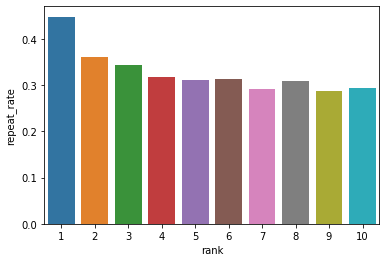

In [7]:
results = {'actual':y_test, 'prob_not':predictions[:,0], 'prob_yes':predictions[:,1]}
results = pd.DataFrame(results)
repeats = results[results['actual'] == 1]
print(len(repeats))
print(len(repeats[repeats['prob_yes'] >= .3]))
print(len(results[results['prob_yes'] >= .3]))
print(len(results))
print(results['prob_yes'].mean())
x = round(len(results)/10)

recreate = X_test
recreate['prob_yes'] = predictions[:,1]
recreate['actual'] = y_test
print(recreate['actual'].mean())

results.sort_values(by=['prob_yes'], ascending=False, inplace=True)
results.reset_index(inplace=True)
results.rename(columns={'index':'customer'}, inplace=True)
results
rank = []
repeat_rate = []
sales_rank_probs = []
lengths = []

for num in range(1,11):
    if num == 10:
        y = results.iloc[x*(num-1):]
        rr = len(results.iloc[x*(num-1):])
    else:
        y = results.iloc[x*(num-1):x*num]
        rr = len(results.iloc[x*(num-1):x*num])
    z = y['actual'].sum()/len(y)
    sales_rank_probs.append(results.iloc[x*(num-1)]['prob_yes'])
    rank.append(num)
    repeat_rate.append(z)
    lengths.append(rr)

sales_rank_probs.append(0)
sales_rank = {'rank':rank, 'repeat_rate':repeat_rate}
sales_rank = pd.DataFrame(sales_rank)
print(lengths)
sales_rank.head(10)

sns.barplot(x='rank', y='repeat_rate', data=sales_rank)
recreate.head()

In [8]:
features = data.drop(columns=['actual'])
labels = data['actual']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train,y_train)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
print(fpr)
print(tpr)
print(thresholds)

[0.         0.         0.         ... 0.99995172 1.         1.        ]
[0.00000000e+00 4.96204039e-05 7.93926463e-04 ... 9.99900759e-01
 9.99900759e-01 1.00000000e+00]
[1.81365824 0.81365824 0.69733059 ... 0.29322204 0.29214304 0.28997846]


In [10]:
logit__roc_auc1 = roc_auc_score(y_test, logreg.predict(X_test))


NameError: name 'logreg' is not defined

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (Sensitivity = %0.3f)' % logit__roc_auc1)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic')
plt.show()

In [11]:
data = pd.read_csv('CaseCompetitionData.csv', sep=',')
data['actual'] = 1
data.loc[data['subsequent_purchases'] == 0, 'actual'] = 0
data = data.loc[(data['purchase_price'] !='?') & (data['customer_income'] != '?') & (data['customer_distance_to_dealer'] != '?')]
data['customer_age'] = data['customer_age'].map({'21 - 30':25, '61 - 70':65, '31 - 40':35, '41 - 50':45, '51 - 60':55, '101+':102, '71 - 80':75,
 '0 - 20':10, '81 - 90':85, '?':'?', '91 - 100':95})
data['customer_income'] = data['customer_income'].map({'20001 - 40000':30000, '80001 - 100000':90000, '40001 - 60000':50000, '60001 - 80000':70000,
 '120001 - 140000':130000, '0 - 20000':10000, '100001 - 120000':110000, '160001 - 180000':170000,
 '200001+':220000, '140001 - 160000':150000, '180001 - 200000':190000})
data['purchase_price'] = data['purchase_price'].map({'10001 - 15000':12500, '15001 - 20000':17500, 
 '20001 - 25000':22500, '25001 - 30000':27500, '30001 - 35000':32500, '0 - 5000':2500, '45001 - 50000':47500, 
 '35001 - 40000':27500, '5001 - 10000':7500, '40001 - 45000':47500, '55001 - 60000':57500, '50001 - 55000':52500, 
 '60001 - 65000':62500, '65001 - 70000':67500, '70001 - 75000':72500, '75001 - 80000':77500, '85001 - 90000':87500,
 '90001 - 95000':92500, '80001 - 85000':82500})

0.32881086172735247


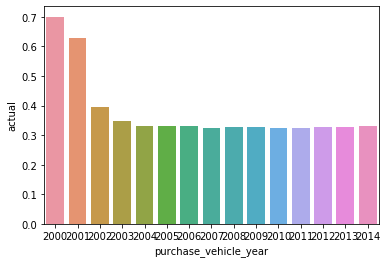

In [12]:
subs = data.loc[data['purchase_vehicle_year'] >= 2000]
#sns.violinplot(x=subs['actual'], y=subs['purchase_vehicle_year']) # checking distribution of car year models against whether they are repeat customers
#looks like a rather similar distribution so this might not be entirely too telling

subs_ratio = data.loc[data['purchase_vehicle_year'] >= 2000].groupby('purchase_vehicle_year')['actual'].mean().to_frame().reset_index()
print(data['actual'].mean())
sns.barplot(x='purchase_vehicle_year', y='actual', data=subs_ratio)

0.32881086172735247


,purchase_price,actual
0,2500,0.670460
1,7500,0.338507
2,12500,0.319115
3,17500,0.325670
4,22500,0.328623
5,27500,0.335492
6,32500,0.330582
7,47500,0.363909
8,52500,0.372401
9,57500,0.431095


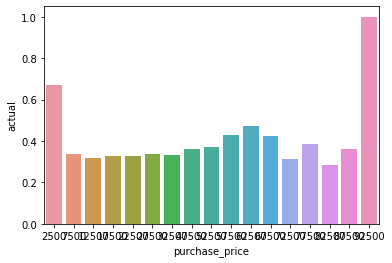

In [13]:
purch_ratio = data.groupby('purchase_price')['actual'].mean().to_frame().reset_index()
print(data['actual'].mean())
sns.barplot(x='purchase_price', y='actual', data=purch_ratio)
purch_ratio

,purchase_price,insert_num
0,2500,1933
1,7500,8118
2,12500,89203
3,17500,102005
4,22500,56402
5,27500,32898
6,32500,12478
7,47500,3674
8,52500,529
9,57500,283


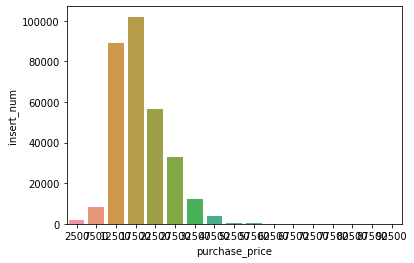

In [14]:
purch_dist = data.groupby('purchase_price')['insert_num'].count().to_frame().reset_index()
sns.barplot(x='purchase_price', y='insert_num', data=purch_dist)
purch_dist

307506
  customer_age  actual
0           10    5083
1           25   75942
2           35   80767
3           45   73392
4           55   45215
5           65   19724
6           75    5282
7           85    1098
8           95      64
9          102     939


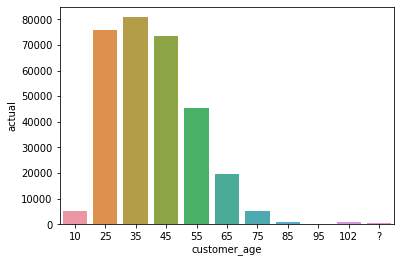

In [15]:
print(len(data[data['customer_age'] != '?'])) # only a couple people have unknown ages
age_counts = data.groupby('customer_age')['actual'].count().to_frame().reset_index()
print(age_counts.head(10))
sns.barplot(x='customer_age', y='actual', data=age_counts)

364

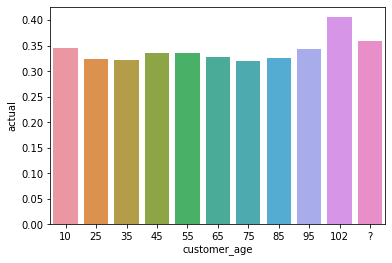

In [16]:
age_buckets = data.groupby('customer_age')['actual'].mean().to_frame().reset_index()
sns.barplot(x='customer_age', y='actual', data=age_buckets)
#interesting that 101+ stands out as a higher liklihood to be a repeat
age_buckets.head()
len(data['customer_age'])-len(data[data['customer_age'] != '?'])
#data[data['customer_age'] == '?'].head(25)


In [17]:
trade_in = data.groupby('trade_in')['actual'].mean().to_frame().reset_index()
print(trade_in.head())
customer_previous_purchase = data.groupby('customer_previous_purchase')['actual'].mean().to_frame().reset_index()
print(customer_previous_purchase.head())

   trade_in    actual
0         0  0.304767
1         1  0.355492
   customer_previous_purchase    actual
0                           0  0.317024
1                           1  0.369935


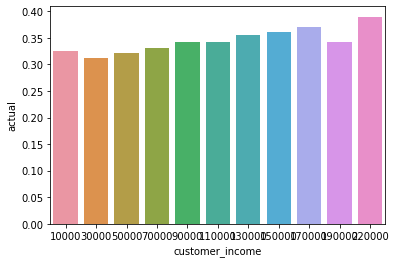

In [18]:
cust_income = data.groupby('customer_income')['actual'].mean().to_frame().reset_index()
sns.barplot(x='customer_income', y='actual', data=cust_income)

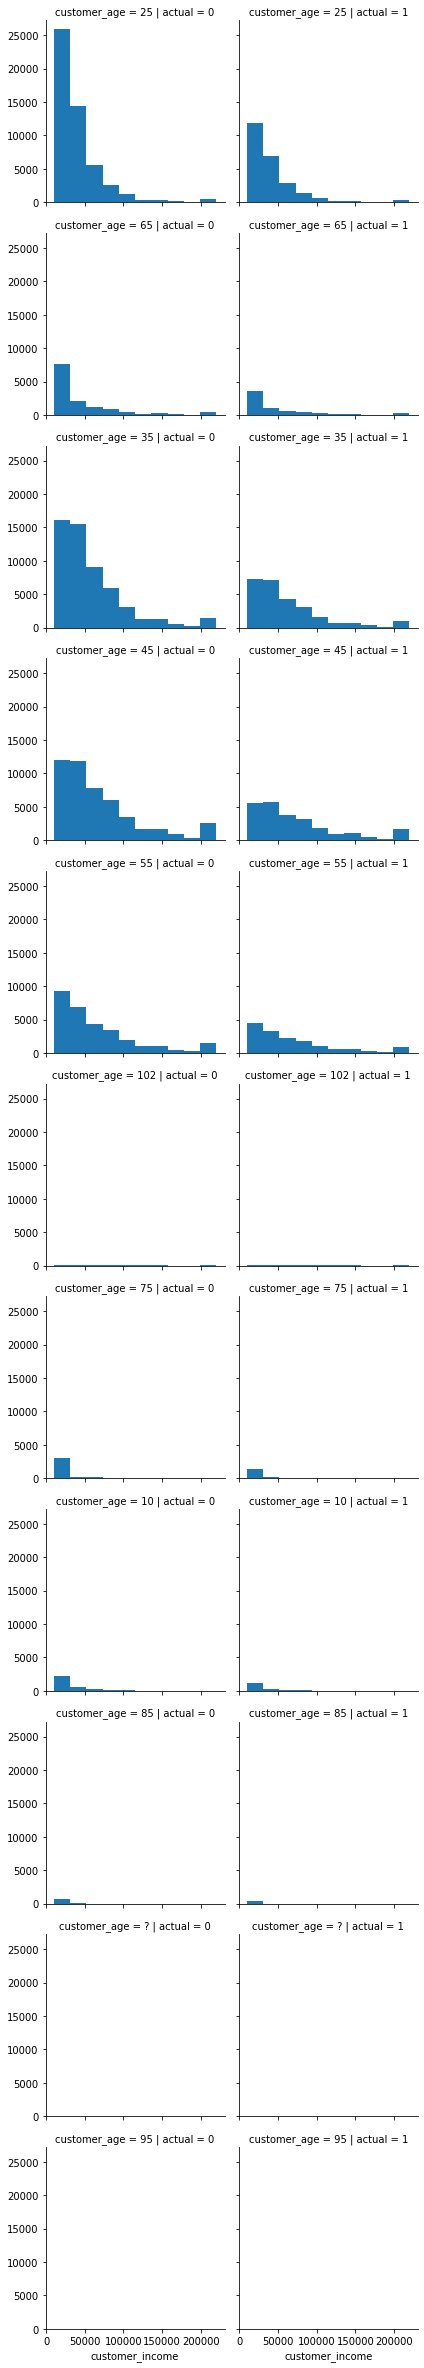

In [19]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(data, col='actual', row='customer_age')
g = g.map(plt.hist, "customer_income")


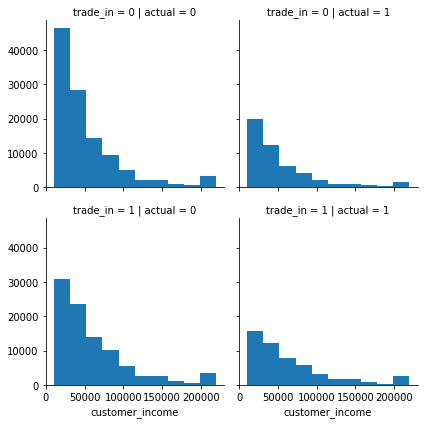

In [20]:
g = sns.FacetGrid(data, col='actual', row='trade_in')
g = g.map(plt.hist, "customer_income")

270861


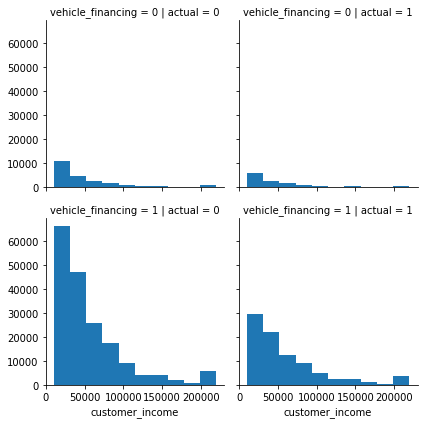

In [22]:
g = sns.FacetGrid(data, col='actual', row='vehicle_financing')
g = g.map(plt.hist, "customer_income")
print(len(data[data['vehicle_financing'] == 1]))
### most people finance (roughly 66%)

In [ ]:
grouping = data.groupby([])